In [1]:
!pip install -q --quiet pogema

     |████████████████████████████████| 694 kB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.1 MB 46.6 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
     |████████████████████████████████| 88 kB 6.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import gym

from pogema import GridConfig
from pogema.wrappers.multi_time_limit import MultiTimeLimit
from pogema.animation import AnimationMonitor
from IPython.display import SVG, display

/usr/local/lib/python3.7/dist-packages/numba/core/types/__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  long_ = _make_signed(np.long)
/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func


In [7]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import time
import numpy as np

N_AGENTS = 8

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.input_shape=363
        self.num_actions=5
        self.load_weights=False
        self.first_move = True

        self.learning_rate = 0.0005
        self.gamma         = 0.98
        self.lmbda         = 0.95
        self.eps_clip      = 0.1
        self.K_epoch       = 2
        self.T_horizon     = 60

        self.data = []
        
        self.fc1   = nn.Linear(self.input_shape, 128)
        self.lstm  = nn.LSTM(128,64)
        self.fc_pi = nn.Linear(64,self.num_actions)
        self.fc_v  = nn.Linear(64,1)
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        if self.load_weights:
            self.load_state_dict(torch.load("pogema_lstm_weights.h5"))
            self.eval()

    def pi(self, x, hidden):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 1, 128)
        x, lstm_hidden = self.lstm(x, hidden)
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=2)
        return prob, lstm_hidden
    
    def v(self, x, hidden):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 1, 128)
        x, lstm_hidden = self.lstm(x, hidden)
        v = self.fc_v(x)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):        
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, h_in_lst, h_out_lst, done_lst = [], [], [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, h_in, h_out, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            h_in_lst.append(h_in)
            h_out_lst.append(h_out)
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
        
        # import pdb
        # pdb.set_trace()
        s,a,r,s_prime,done_mask,prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                         torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                         torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s,a,r,s_prime, done_mask, prob_a, h_in_lst[0], h_out_lst[0]
        
    def train_net(self):
        s,a,r,s_prime,done_mask, prob_a, (h1_in, h2_in), (h1_out, h2_out) = self.make_batch()
        first_hidden  = (h1_in.detach(), h2_in.detach())
        second_hidden = (h1_out.detach(), h2_out.detach())
        if s.shape == (1, 0):
            return

        for i in range(self.K_epoch):
            v_prime = self.v(s_prime, second_hidden).squeeze(1)
            td_target = r + self.gamma * v_prime * done_mask
            v_s = self.v(s, first_hidden).squeeze(1)
            delta = td_target - v_s
            delta = delta.detach().numpy()
            
            advantage_lst = []
            advantage = 0.0
            for item in delta[::-1]:
                advantage = self.gamma * self.lmbda * advantage + item[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi, _ = self.pi(s, first_hidden)
            pi_a = pi.squeeze(1).gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == log(exp(a)-exp(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(v_s, td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward(retain_graph=True)
            self.optimizer.step()

    def act(self, obs, dones=None, positions_xy=None, targets_xy=None) -> list:
        """
        Given current observations, Done flags, agents' current positions and their targets, produce actions for agents.
        """        
        if self.first_move:
            self.h_outs = []
            for i in range(len(obs)):
                self.h_outs.append([(torch.zeros([1, 1, 64], dtype=torch.float), 
                                torch.zeros([1, 1, 64], dtype=torch.float))])
            self.first_move = False

        actions = []
        for i in range(len(obs)):
            h_in = self.h_outs[i]
            s_current = obs[i].flatten()
            prob, self.h_outs[i] = self.pi(torch.from_numpy(s_current).float(), h_in)            
            m = Categorical(prob)
            a = m.sample().item()
            actions.append(a)
        return actions

r_mem = np.zeros(N_AGENTS)

def reset_rewards():
  global r_mem
  r_mem = np.zeros(N_AGENTS)

# Идея: шаг в направлении цели на радаре получает бонус
def navigation_reward(state, action):
    #import pdb
    #pdb.set_trace()
    moves = np.array([(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)])
    center = np.array((5, 5))
    ind = np.unravel_index(np.argmax(state[2], axis=None), state[2].shape)
    dist1 = np.linalg.norm(ind - center)
    dist2 = np.linalg.norm(ind - (center + moves[action]))
    #print(f'dist1: {dist1}  dist2: {dist2}')
    if dist2 <= dist1:
        return 1
    else:
        return 0

def dist_func_reward():
  return 

# Идея: дополнительнй штраф за неподвижность
def stop_reward(s_current, s_next):
    if np.allclose(s_current, s_next):
        return  0
    else:
        return 1
r_data= []
r_mem_data= []
max_r = 20.0

def store_data(states, actions, states_next, rewards, h_ins, h_outs, dones, model):    
    for i in range(len(states)):
        # if dones[i]: 
            # continue
        s_current = states[i].flatten()
        prob, _ = model.pi(torch.from_numpy(s_current).float(), h_ins[i])
        prob = prob.view(-1)
        s_next = states_next[i].flatten()
        a = actions[i]
        if(dones[i]):
          if steps < 255:
            r = 100.0
          else:
            r = -10
        else:
          r = dones[i]
          #r += 2 / 256
          #r += (stop_reward(s_current, s_next) + navigation_reward(states[i], a)) / 100
          nav_r = navigation_reward(states[i], a)
          stop_r = stop_reward(s_current, s_next)
          if nav_r and stop_r:
            r_mem[i] += nav_r
          else:
            r_mem[i] = 0.0
          r += ((stop_r * nav_r * 2) + (r_mem[i] * 8) - 3)
          #r /= 100
          #if(r<0): r=1.0

          if(r > max_r): r=max_r
        r_mem_data.append(r_mem[i])
        r_data.append(r)
        #r += stop_reward(s_current, s_next) + navigation_reward(states[i], a)        
        # import pdb
        # pdb.set_trace()
        model.put_data((s_current, a, r, s_next, prob[a].item(), h_ins[i], h_outs[i], dones[i]))

def gen_actions(states, model, h_ins):
    actions = []
    h_outs = []
    for i in range(len(states)):
        s_current = states[i].flatten()
        prob, h_out = model.pi(torch.from_numpy(s_current).float(), h_ins[i]) 
        m = Categorical(prob)
        a = m.sample().item()
        actions.append(a)
        h_outs.append(h_out)
    return actions, h_outs


def play_game():    
        states_current = env.reset()    
        dones = [False, ...]
        while(not all(dones)): 
            actions = model.act(states_current)
            states_next, rewards, dones, info = env.step(actions)
            #env.render()            
            states_current = states_next

# Define random configuration
grid_config = GridConfig(num_agents=N_AGENTS, # количество агентов на карте
                          size=8,      # размеры карты
                          density=0.3,  # плотность препятствий
                          #seed=1,       # сид генерации задания 
                          max_episode_steps=256,  # максимальная длина эпизода
                          obs_radius=5, # радиус обзора
                        )

env = gym.make("Pogema-v0", grid_config=grid_config)
env = AnimationMonitor(env)

# обновляем окружение
obs = env.reset()

model = Model()
model= torch.load("/content/drive/MyDrive/Hacks-ai/pogema_lstm_weights_340.h5")
model.eval()

/usr/local/lib/python3.7/dist-packages/gym/utils/env_checker.py:50: UserWarning: WARN: It seems that your observation  is an image but the `dtype` of your observation_space is not `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  f"It seems that your observation {key} is an image but the `dtype` "
/usr/local/lib/python3.7/dist-packages/gym/utils/env_checker.py:58: UserWarning: WARN: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  f"It seems that your observation space {key} is an image but the "
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:620: UserWarning: WARN: Env check failed with the following message: The observation returned by `reset()` method must be a numpy array
You can set `disable_env_checker=True` to

Model(
  (fc1): Linear(in_features=363, out_features=128, bias=True)
  (lstm): LSTM(128, 64)
  (fc_pi): Linear(in_features=64, out_features=5, bias=True)
  (fc_v): Linear(in_features=64, out_features=1, bias=True)
)

# of episode :20, avg score : 0.6, steps : 256


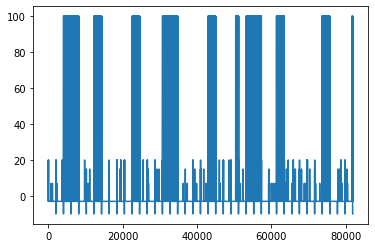

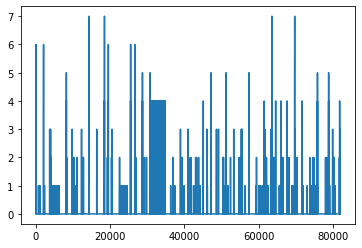

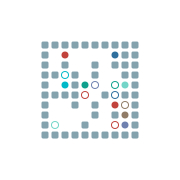

# of episode :40, avg score : 0.3, steps : 256


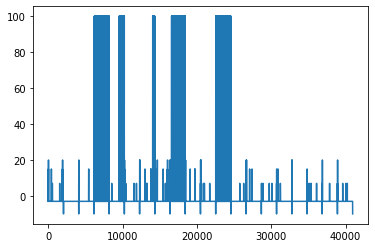

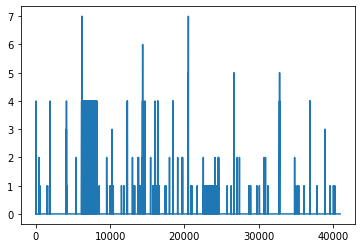

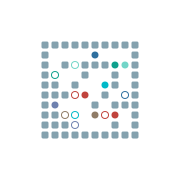

# of episode :60, avg score : 0.7, steps : 256


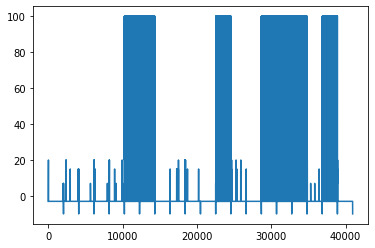

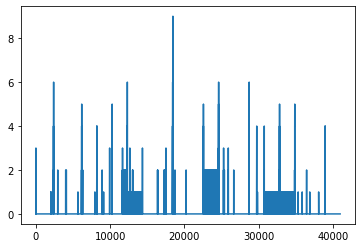

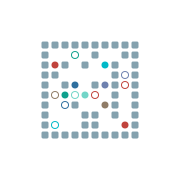

# of episode :80, avg score : 0.5, steps : 256


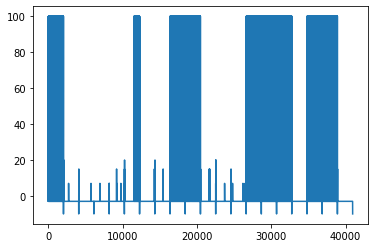

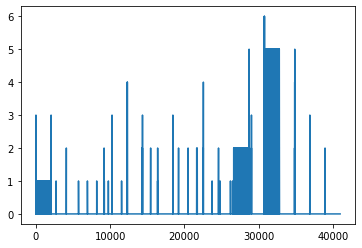

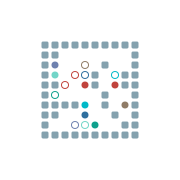

# of episode :100, avg score : 0.5, steps : 256


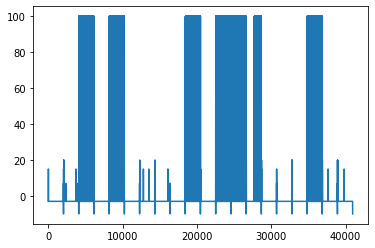

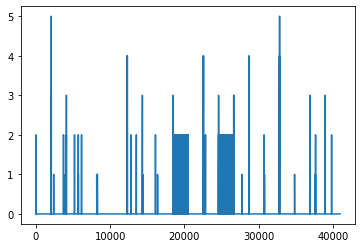

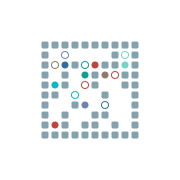

# of episode :120, avg score : 0.8, steps : 256


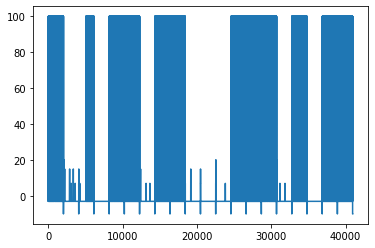

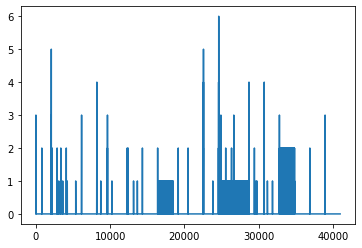

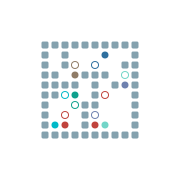

# of episode :140, avg score : 0.5, steps : 256


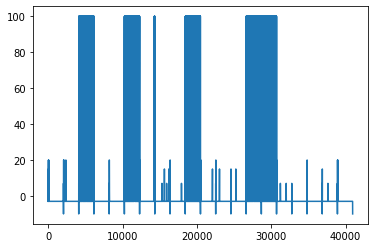

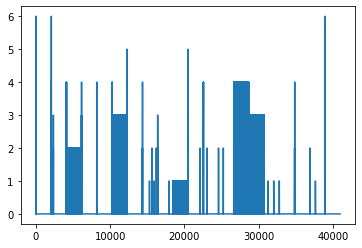

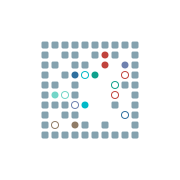

# of episode :160, avg score : 0.7, steps : 256


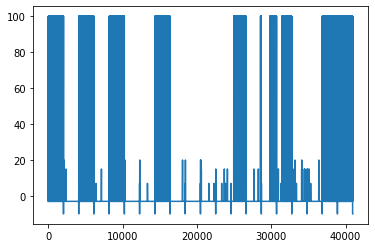

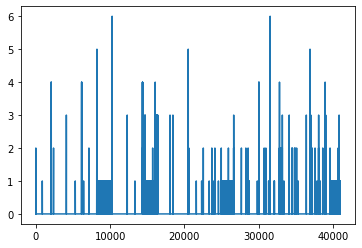

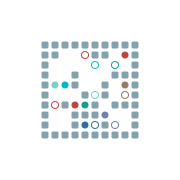

# of episode :180, avg score : 1.2, steps : 256


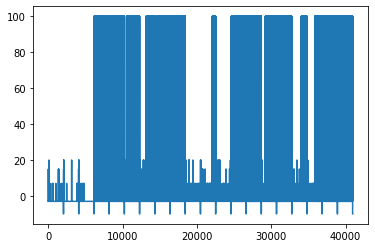

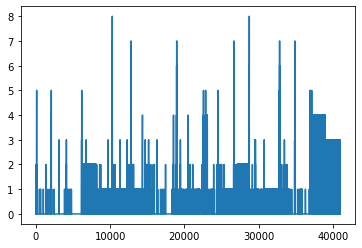

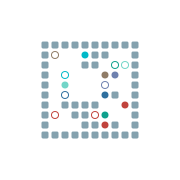

In [11]:
score = 0.0
print_interval = 20
#cluster_iterations = 10000
iterations = 200
min_play_reward = 50


import matplotlib.pyplot as plt
def plot_r_data():
  global r_data, r_mem_data
  plt.plot(r_data)
  plt.show()
  r_data = []
  plt.plot(r_mem_data)
  plt.show()
  r_mem_data=[]
  
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#model = model.to('cpu')

for iteration in range(iterations):
    states_current = env.reset()
    h_outs = [(torch.zeros([1, 1, 64], dtype=torch.float), torch.zeros([1, 1, 64], dtype=torch.float))] * len(states_current)
    dones = [False, ...]
    steps = 0
    while not all(dones):
        for t in range(model.T_horizon): 
            h_ins = h_outs
            actions, h_outs = gen_actions(states_current, model, h_ins)
            states_next, rewards, dones, info = env.step(actions)
            store_data(states_current, actions, states_next, rewards, h_ins, h_outs, dones, model)
            states_current = states_next
            score += sum(rewards)
            steps += 1

            if all(dones):
                if score/print_interval > min_play_reward:
                    play_game()
                break

        model.train_net()

    if iteration % print_interval == 0 and iteration != 0:
        print("# of episode :{}, avg score : {:.1f}, steps : {}".format(iteration, score/print_interval, steps))
        score = 0.0
        plot_r_data()
        env.save_animation("render.svg")
        display(SVG('render.svg'))
        torch.save(model.state_dict(), "/content/drive/MyDrive/Hacks-ai/pogema_lstm/pogema_lstm_weights_{}.h5".format(iteration))

env.close()

In [13]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Hacks-ai/pogema_lstm/pogema_lstm_weights_last.h5")